In [47]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python  

In [48]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression

from sklearn.manifold import MDS          # multidimensional scaling
from sklearn.random_projection import GaussianRandomProjection # random projection
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import euclidean_distances

In [49]:
df = pd.read_csv('unconv_MV_v4.csv')      # load our data table 
df['TOC'] = np.where(df['TOC']<0.0, 0.0, df['TOC']) # set TOC < 0.0 as 0.0, otherwise leave the same

In [50]:
df.head(n=13)                             # we could also use this command for a table preview

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624
5,6,14.53,4.81,2.69,53.60,0.94,1.67,4017.374438
6,7,13.49,3.60,2.93,63.71,0.80,1.85,2952.812773
7,8,11.58,3.03,3.25,53.00,0.69,1.93,2670.933846
8,9,12.52,2.72,2.43,65.77,0.95,1.98,2474.048178
9,10,13.25,3.94,3.71,66.20,1.14,2.65,2722.893266


In [51]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.991950,0.478264,0.000000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303506,4752.637555,8590.384044


In [52]:
pormin = 6.0; pormax = 24.0; porname = 'Porosity (%)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
permmin = 0.0; permmax = 10; permname = 'Permeability (mD)'; permtitle = 'Permeability'                
AImin = 1.0; AImax = 5.0; AIname = 'Acoustic Impedance (kg/m2s*10^6)'; AItitle = 'Acoustic Impedance'
brmin = 10.0; brmax = 85.0; brname = 'Brittleness Ratio (%)'; brtitle = 'Brittleness'
TOCmin = 0.0; TOCmax = 2.2; TOCname = 'Total Organic Carbon (%)'; TOCtitle = 'Total Organic Carbon' 
VRmin = 0.9; VRmax = 2.9; VRname = 'Vitrinite Reflectance (%)'; VRtitle = 'Vitrinite Reflectance'
prodmin = 500.0; prodmax = 9000.0; prodname = 'Normalized Initial Production (MCFPD)'; prodtitle = 'Normalized Initial Production'

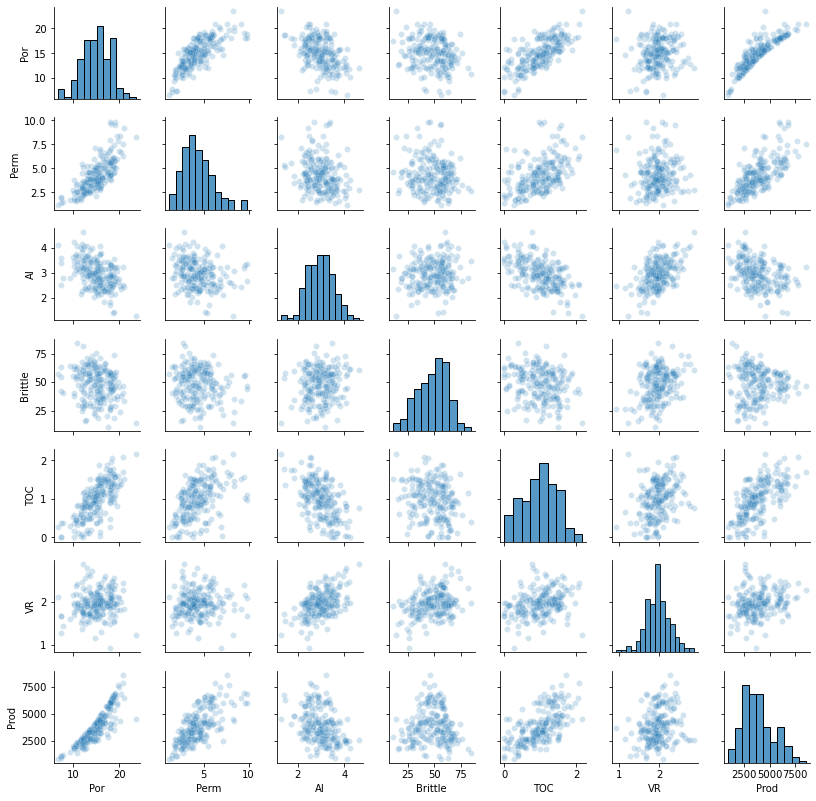

In [53]:
sns.pairplot(df,vars=['Por','Perm','AI','Brittle','TOC','VR','Prod'],markers='o',plot_kws={'alpha': 0.2})
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.6, wspace=0.3, hspace=0.2)
plt.show()

In [54]:
from sklearn.preprocessing import StandardScaler

features = ['Por','AI','TOC']
x = df.loc[:,features].values
mu = np.mean(x, axis=0)
sd = np.std(x, axis=0)
xs = StandardScaler().fit_transform(x)

ns_features = []
for i in range(0,len(features)):
    df['NS_'+features[i]] = xs[:,i]
    ns_features.append('NS_'+features[i]) 

df.head(n=13)


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod,NS_Por,NS_AI,NS_TOC
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819,-0.982256,-0.298603,0.352257
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063,-0.881032,0.444147,-0.213702
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259,-0.327677,1.841224,-0.213702
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854,0.903875,-0.599240,0.184565
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624,0.853263,0.373409,1.085907
5,6,14.53,4.81,2.69,53.60,0.94,1.67,4017.374438,-0.155597,-0.493133,-0.108895
6,7,13.49,3.60,2.93,63.71,0.80,1.85,2952.812773,-0.506505,-0.068704,-0.402355
7,8,11.58,3.03,3.25,53.00,0.69,1.93,2670.933846,-1.150962,0.497200,-0.632930
8,9,12.52,2.72,2.43,65.77,0.95,1.98,2474.048178,-0.833795,-0.952930,-0.087933
9,10,13.25,3.94,3.71,66.20,1.14,2.65,2722.893266,-0.587484,1.310688,0.310334


In [55]:
bins = [0,2500,5000,7500,10000]                # assign the production bins (these are the fence posts)
labels = ['low', 'med', 'high', 'vhigh']       # assign the labels
category = pd.cut(df['Prod'],bins,labels=labels)     # make the 1D array with the labels for our data
df['tProd'] = category                                # add the new ordinal production feature to our DataFrames    
df.head()
dpalette = sns.color_palette("rocket_r",n_colors = 4)
palette = sns.color_palette("rocket")

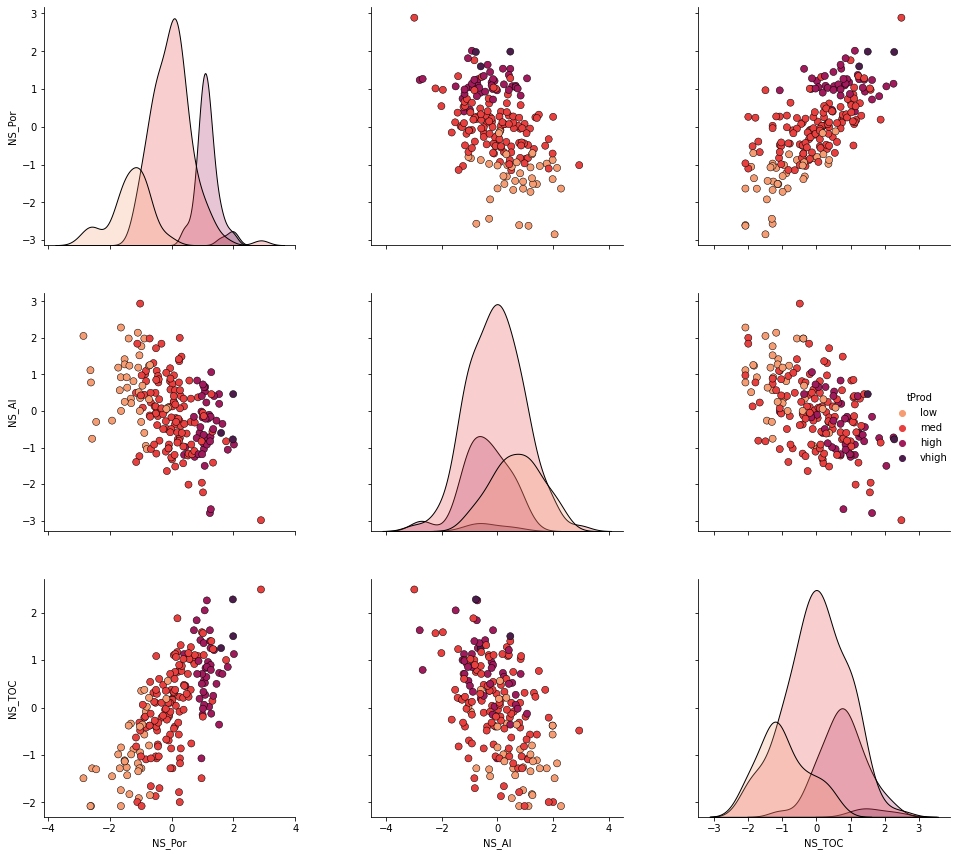

In [56]:
plot = sns.pairplot(df[ns_features + ['tProd']],markers='o',hue = 'tProd', palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5))

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.3, hspace=0.2)
plt.show()

In [57]:
np.random.seed(1867)                               # set the random number seed, so we all get the same answer
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,n_init = 20,max_iter = 1000,random_state = 73073) # instantiate and set the hyperparameter
MDS_transformed = embedding.fit_transform(df[ns_features])
MDS_transformed.shape

(200, 2)

In [58]:
df['MDS1'] = MDS_transformed[:,0]
df['MDS2'] = MDS_transformed[:,1]
df.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod,NS_Por,NS_AI,NS_TOC,tProd,MDS1,MDS2
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819,-0.982256,-0.298603,0.352257,low,0.610034,-0.645613
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063,-0.881032,0.444147,-0.213702,med,0.877231,0.299790
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259,-0.327677,1.841224,-0.213702,med,0.478352,1.842171
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854,0.903875,-0.599240,0.184565,high,-0.884147,-0.479161
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624,0.853263,0.373409,1.085907,med,-1.382521,0.425827


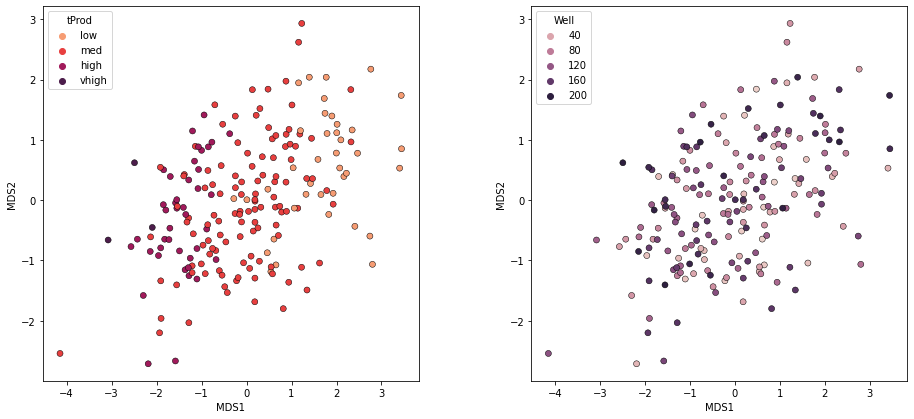

In [59]:
plt.subplot(121)
pairplot = sns.scatterplot(x = df['MDS1'],y = df['MDS2'],hue = df['tProd'],markers='o',palette = dpalette,edgecolor="black")

plt.subplot(122)
pairplot = sns.scatterplot(x = df['MDS1'],y = df['MDS2'],hue = df['Well'],markers='o',edgecolor="black")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.3, wspace=0.3, hspace=0.2,)
plt.show()

Distance Ratio, mean: 0.95, standard deviation 0.15.


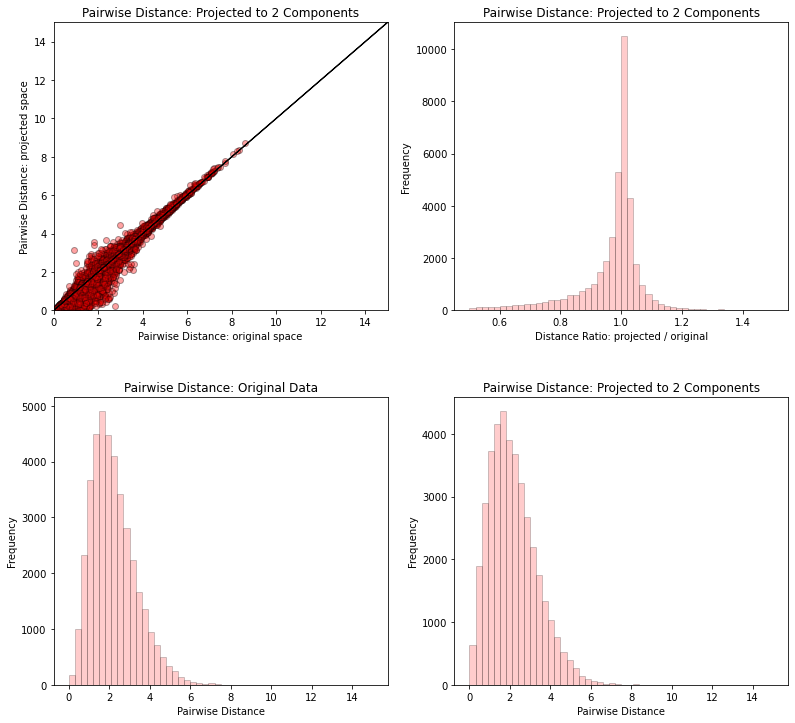

In [60]:
dists = euclidean_distances(df[ns_features], squared=False).ravel()
nonzero = dists != 0   # select only non-identical samples pairs
dists = dists[nonzero]
projected_dists = euclidean_distances(MDS_transformed, squared=False).ravel()[nonzero]

plt.subplot(221)
plt.scatter(dists,projected_dists,c='red',alpha=0.2,edgecolor = 'black')
plt.arrow(0,0,200,200,width=0.02,color='black',head_length=0.0,head_width=0.0)
plt.xlim(0,15); plt.ylim(0,15)
plt.xlabel("Pairwise Distance: original space")
plt.ylabel("Pairwise Distance: projected space")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

rates = projected_dists / dists
print("Distance Ratio, mean: %0.2f, standard deviation %0.2f." % (np.mean(rates), np.std(rates)))

plt.subplot(222)
plt.hist(rates, bins=50, range=(0.5, 1.5),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Distance Ratio: projected / original")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplot(223)
plt.hist(dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Original Data")

plt.subplot(224)
plt.hist(projected_dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=2.3, wspace=0.2, hspace=0.3)
plt.show()

In [61]:
df_subset = df.iloc[:30,:]


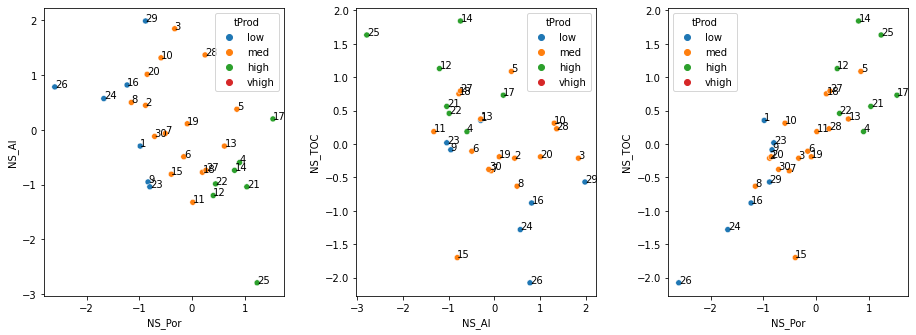

In [62]:
plt.subplot(131)
pairplot = sns.scatterplot(x = df_subset[ns_features[0]],y = df_subset[ns_features[1]],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset[ns_features[0]][i], df_subset[ns_features[1]][i]))
    
plt.subplot(132)
pairplot = sns.scatterplot(x = df_subset[ns_features[1]],y = df_subset[ns_features[2]],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset[ns_features[1]][i], df_subset[ns_features[2]][i]))
    
plt.subplot(133)
pairplot = sns.scatterplot(x = df_subset[ns_features[0]],y = df_subset[ns_features[2]],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset[ns_features[0]][i], df_subset[ns_features[2]][i]))
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.3, hspace=0.2)
plt.show()

In [63]:
embedding_subset = MDS(n_components=2)
MDS_transformed_subset = embedding_subset.fit_transform(df_subset[ns_features])
MDS_transformed_subset.shape

(30, 2)

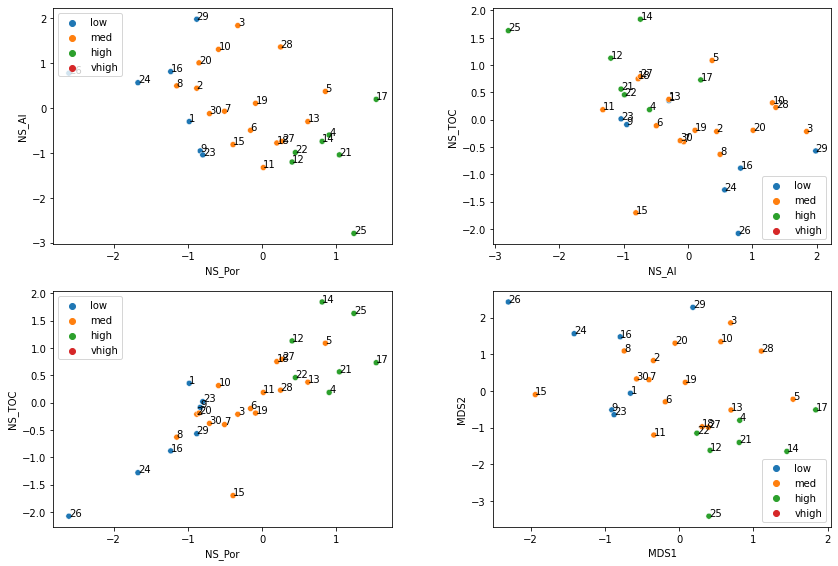

In [64]:
plt.subplot(221)
pairplot = sns.scatterplot(x = df_subset[ns_features[0]],y = df_subset[ns_features[1]],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset[ns_features[0]][i], df_subset[ns_features[1]][i]))
pairplot.legend(loc='upper left')  

plt.subplot(222)
pairplot = sns.scatterplot(x = df_subset[ns_features[1]],y = df_subset[ns_features[2]],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset[ns_features[1]][i], df_subset[ns_features[2]][i]))
pairplot.legend(loc='lower right')     
    
plt.subplot(223)
pairplot = sns.scatterplot(x = df_subset[ns_features[0]],y = df_subset[ns_features[2]],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (df_subset[ns_features[0]][i], df_subset[ns_features[2]][i]))
pairplot.legend(loc='upper left')     
    
plt.subplot(224)
pairplot = sns.scatterplot(x = MDS_transformed_subset[:,0],y = MDS_transformed_subset[:,1],hue = df_subset['tProd'],markers='o')
for i, txt in enumerate(df_subset['Well']):
    pairplot.annotate(txt, (MDS_transformed_subset[i,0], MDS_transformed_subset[i,1]))
pairplot.set_xlabel('MDS1'); pairplot.set_ylabel('MDS2')  
pairplot.legend(loc='lower right') 

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.8, wspace=0.3, hspace=0.2)
plt.show()

Distance Ratio, mean: 0.86, standard deviation 0.17.


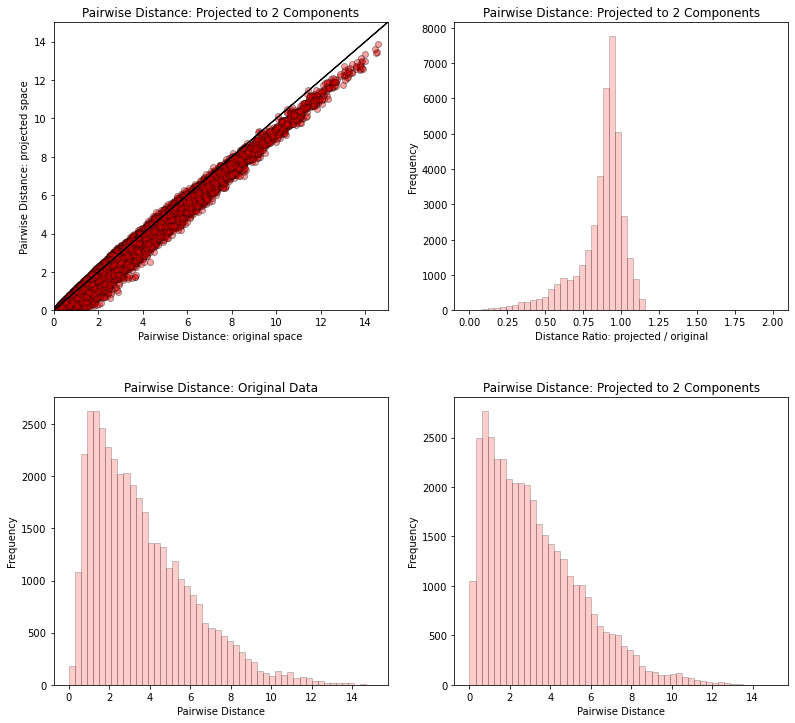

In [65]:
n_components = 2; seed = 73058
rp = GaussianRandomProjection(n_components=n_components,random_state = seed)

dists = euclidean_distances(df[['Por','AI','TOC']], squared=False).ravel()
nonzero = dists != 0   # select only non-identical samples pairs
dists = dists[nonzero]

projected_data = rp.fit_transform(df[['Por','AI','TOC']])
projected_dists = euclidean_distances(projected_data, squared=False).ravel()[nonzero]

plt.subplot(221)
plt.scatter(dists,projected_dists,c='red',alpha=0.2,edgecolor = 'black')
plt.arrow(0,0,200,200,width=0.02,color='black',head_length=0.0,head_width=0.0)
plt.xlim(0,15); plt.ylim(0,15)
plt.xlabel("Pairwise Distance: original space")
plt.ylabel("Pairwise Distance: projected space")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

rates = projected_dists / dists
print("Distance Ratio, mean: %0.2f, standard deviation %0.2f." % (np.mean(rates), np.std(rates)))

plt.subplot(222)
plt.hist(rates, bins=50, range=(0., 2.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Distance Ratio: projected / original")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplot(223)
plt.hist(dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Original Data")

plt.subplot(224)
plt.hist(projected_dists, bins=50, range=(0., 15.),color = 'red', alpha = 0.2, edgecolor='k')
plt.xlabel("Pairwise Distance")
plt.ylabel("Frequency")
plt.title("Pairwise Distance: Projected to %d Components" % n_components)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=2.3, wspace=0.2, hspace=0.3)
plt.show()